# **Imports e Installs**

In [23]:
#@title Imports

# Básicos
from logging import warning
import pandas as pd
import numpy as np
import geopandas as gpd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt

# Pysal
!pip install geopandas pysal
import libpysal
import json

!pip install esda

from shapely.wkt import loads

# esda e pysal
from esda.geary import Geary
from pysal.explore import esda
import libpysal as lps
from libpysal import weights
from libpysal.weights import Queen
from libpysal.weights import full2W
from scipy.spatial import distance_matrix
from esda import Moran, Moran_Local, G_Local


# skgstat
!pip install scikit-gstat
!pip install gstools
import gstools as gs
import skgstat as skg
from skgstat import OrdinaryKriging

# Torch
!pip install torch-geometric
import networkx as nx
import torch
from torch_geometric.data import Data
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv

# Barra de progresso
from tqdm.auto import tqdm

# Sklearn
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GroupKFold

# Regressão
from spreg import GM_Error
from spreg import GM_Lag
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.stats import kstest
from scipy.spatial import distance_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor
from libpysal.weights import Queen, Rook, DistanceBand, KNN

# UMAP
!pip install umap-learn
import umap.umap_ as umap

# warnings
import warnings
warnings.filterwarnings('ignore')

from spreg import ML_Lag

In [2]:
from os import path
#@title Import nos dados pelo GIT

!git clone https://github.com/MurilloYumoto/Analise-Criminal-no-Brasil

path = '/content/Analise-Criminal-no-Brasil/Base_final/2014/2014.shp'
path_gini = '/content/Analise-Criminal-no-Brasil/docs/gini_2010 - Página1.csv'
path_regiao_imediata = '/content/Analise-Criminal-no-Brasil/Shapefiles_auxiliares/regiao_geografica_imediata/Regiao Geografica Imediata.shp'

Cloning into 'Analise-Criminal-no-Brasil'...
remote: Enumerating objects: 288, done.
remote: Counting objects: 100% (103/103), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 288 (delta 45), reused 73 (delta 30), pack-reused 185 (from 1)
Receiving objects: 100% (288/288), 81.38 MiB | 15.88 MiB/s, done.
Resolving deltas: 100% (114/114), done.
Updating files: 100% (132/132), done.


# **Sobre os modelos de predição**

#### **Problemas da previsão do índice de criminalidade**

Uma primeira vista ao problema subentende que a etapa final, destinada aos modelos de predição, visa aplicar métodos de regressão a fim de obter estimadores para o índice de criminalidade para cada município. A forma com a qual é constituído o índice, porém, introduz alguns vieses a análise, o que dificultava a predição.

Cita-se, por exemplo, que os pesos atribuídos aos diferentes crimes eram arbitrários e falhavam na tentativa de quantificar a gravidade de diferentes ocorrências: um homicídio não deve ser comparado a um número "$n$" de furtos, são equivalências que não fazem sentido.

Uma outra problemática diz respeito à representatividade de crimes hediondos, cuja natureza os restringia apenas às grandes cidades, ao passo que não haviam ocorrências na maior parte do território, afetando o fenômeno de autocorrelação espacial de grande interesse neste trabalho.

#### **Número de roubos totais**

Optou-se, portanto, por dar continuidade ao estudo através do número de incidências de roubos totais para cada município, uma vez que:

**1.** A contagem de roubos, em se tratando de um único valor absoluto, não é afetada pelo viés do índice.

**2.** Roubos representam o tipo de crime com o maior número de ocorrências e são mais bem distribuídos ao longo do Estado, permitindo uma análise mais robusta.

# **Filtragem e processamento dos dados**

### **Sistema de coordenadas cartográficas**

Ao trabalhar com dados espaciais representados por coordenadas geográficas leva-se em consideração que elas estão baseadas em uma superfície curva e, por conseguinte, introduzem distorções significativas no cálculo das distâncias e áreas. Em se tratando uma análise local (restrita ao Estado de São Paulo) é necessário converter as coordenadas geográficas de todos os pontos para um espaço de coordenadas adequado, uma vez que toda planificação introduz algum tipo de distorção em detrimento de preservar propriedades espaciais (distâncias, áreas, etc).


#### **Zona UTM23S**

A Zona 23S da projeção UTM abrange a maior parte do estado de São Paulo. Utilizar essa projeção garante que a maioria dos municípios estejam bem representados, evitando distorções significativas que ocorrem quando dados são projetados fora da zona apropriada.



In [3]:
df = gpd.read_file(path)

# Convertendo o sistema de coordenadas para a projeção
print(f"CRS atual: {df.crs}")
df = df.to_crs('EPSG:32723')
df.head()

df['centroid'] = df.geometry.centroid

df['x_centroid'] = df['centroid'].x
df['y_centroid'] = df['centroid'].y

gini = pd.read_csv(path_gini)
gini['Cod'] = gini['Cod'].astype(int)
gini['Gini'] = gini['Gini'].astype(str).str.replace(',', '.').astype(float)
df['Codigo sem digito'] = ((df['cod_ibge'] - (df['cod_ibge'] % 10)) / 10).astype(int)
df = df.merge(gini, left_on='Codigo sem digito', right_on='Cod', how='left')

df.drop('Codigo sem digito', axis=1, inplace=True)
df.drop('Município', axis=1, inplace=True)
df.drop('Cod', axis=1, inplace=True)

CRS atual: EPSG:4674


# **Autocorrelação espacial**

Faz-se, aqui, uma breve seção de exploração da natureza espacial dos dados de roubo, que serve para justificar as escolhas de modelo adiante.

## **Krigagem**

Krigagem é uma técnica de interpolação geoestatística em que os valores "preditos" são simulados a partir de um Processo Gaussiano sob suposição de uma covariância definida a partir do "variograma". O variograma, por sua vez, é uma função que quantifica a diferença média entre valores de uma variável em dois pontos separados por uma distância específica, a qual define-se por:





$$
\gamma(h) = \frac{1}{2N(h)} \sum_{i=1}^{N(h)} \left[ Z(x_i) - Z(x_i + h) \right]^2
$$

Em que:

*   $\gamma(h)$: É o valor do variograma para uma distância $h$.
*   $N(h)$: Número de pares de pontos separados pela distância $h$.
*   $Z(x_i)$ e $Z(x_i + h)$: São os valores da variável nos pontos $x_i$ e $x_i + h$.

Em se tratando de uma técnica de interpolação, a krigagem é majoritariamente usada para predizer novas observações. Vale ressaltar que ela leva em consideração apenas os valores do Índice Criminal e a dependência espacial dos dados, aqui calculada a partir da matriz de distância inversa. Por isso, faz-se aqui uma forma de "confirmar" o fenômeno de autocorrelação espacial: se um modelo de variograma é capaz de prever eficientemente os valores omissos, valida-se a suposição de dependência no espaço.

Conforme já testado no notebook de análise exploratória, a krigagem é feita a partir do Leave One Out Cross Validation.

In [4]:
X = df[['x_centroid', 'y_centroid']].values
y = (df['TR2014'] * 1000 / df['populacao']).values

In [ ]:
loo = LeaveOneOut()

y_pred = []
y_true = []

for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    V = skg.Variogram(X, y, model='stable', normalize=False, use_nugget=True, maxlag=0.7, n_lags=15, fit_method='trf')

    OK = OrdinaryKriging(V, mode='exact')

    y_k_pred = OK.transform(X_test)

    y_pred.append(y_k_pred[0])
    y_true.append(y_test[0])

y_pred = np.array(y_pred)
y_true = np.array(y_true)

mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)
r2 = r2_score(y_true, y_pred)

print(f'Erro Médio Absoluto (MAE): {mae}')
print(f'Raiz do Erro Quadrático Médio (RMSE): {rmse}')
print(f'Coeficiente de Determinação (R²): {r2}')

Erro Médio Absoluto (MAE): 0.7232701481213889
Raiz do Erro Quadrático Médio (RMSE): 1.1807772867137154
Coeficiente de Determinação (R²): 0.7213448995403327


In [ ]:
#@title Distribuição dos valores preditos

df_krigagem = df.copy()

df_krigagem['RV previsto'] = y_pred
df_krigagem['taxa RV'] = y

df_krigagem['Erro'] = df_krigagem['taxa RV'] - df_krigagem['RV previsto']

erro_absoluto = np.abs(df_krigagem['Erro'])

df_krigagem['Erro absoluto'] = erro_absoluto

fig = px.scatter(df_krigagem, x="taxa RV", y="RV previsto", color="Erro absoluto", title="Validação cruzada Leave One Out", color_continuous_scale='Agsunset')

fig.update_layout(
    xaxis_title="IC2014",
    yaxis_title="IC previsto",
    showlegend=True)

fig.add_trace(
    go.Scatter(
        x=[y_true.min(), y_true.max()],
        y=[y_true.min(), y_true.max()],
        mode='lines',
        line=dict(color='black'),
        showlegend=False
    )
)

fig.show()

# **Modelos preditores**

## **Baseline: alguns modelos para teste**

Um baseline em modelos de regressão é uma abordagem simples e inicial usada como referência para avaliar o desempenho de modelos mais sofisticados. Ele serve como um "ponto de partida" para medir se as técnicas mais avançadas realmente trazem melhorias.

Aqui, faz-se a regressão da incidência de roubos por município por meio de alguns modelos "simples", isto é, que não consideram a relação espacial entre os dados, tal como modelos de árvore (Random Forest) e modelos lineares (Regressão Linear Simples e Múltipla).

In [35]:
#@title Random Forest Regressor

from sklearn.ensemble import RandomForestRegressor
tqdm.pandas(desc="Progress")


X_baseline = df[['Area_Km2', 'IPDM', 'CAER', 'CAEC',
           'RTF', 'IndRiq', 'TMI', 'TMP', 'TM1539', 'TM6069',
            'TAE03','IndLong', 'TAE03',
            'Prof5ano', 'Prof9ano', 'TDISM',
           'IndEsc', 'populacao', 'Agrop', 'Gini', 'Indústria', 'AdmPub', 'ServExc',
          'ValAdic', 'ImpLiq', 'PIB', 'PIBpc']]

y_baseline = (df['TR2014'] * 1000 / df['populacao']).values

Y_pred_rf = []

loo = LeaveOneOut()

for train_index, test_index in tqdm(loo.split(X_baseline), total=loo.get_n_splits(X_baseline), desc = 'Progress', leave=False):
    X_train_base, X_test_base = X_baseline.iloc[train_index], X_baseline.iloc[test_index]
    y_train_base, y_test_base = y_baseline[train_index], y_baseline[test_index]

    model = RandomForestRegressor()
    model.fit(X_train_base, y_train_base)

    y_pred = model.predict(X_test_base)
    Y_pred_rf.append(y_pred[0])

r2_rf = r2_score(y_baseline, Y_pred_rf)
mae_rf = mean_absolute_error(y_baseline, Y_pred_rf)
rmse_rf = mean_squared_error(y_baseline, Y_pred_rf, squared=False)

print(f'R2: {r2_rf}')
print(f'MAE: {mae_rf}')
print(f'RMSE: {rmse_rf}')

Progress:   0%|          | 0/640 [00:00<?, ?it/s]

R2: 0.7066095216503689
MAE: 0.72223724566614
RMSE: 1.211595076286531


In [36]:
#@title Distribuição dos valores preditos

df_print = df.copy()

df_print['RV previsto'] = Y_pred_rf
df_print['taxa RV'] = y_baseline

df_print['Erro'] = df_print['taxa RV'] - df_print['RV previsto']

erro_absoluto = np.abs(df_print['Erro'])

df_print['Erro absoluto'] = erro_absoluto

fig = px.scatter(df_print, x="taxa RV", y="RV previsto", color="Erro absoluto", title="Validação cruzada Leave One Out", color_continuous_scale='Agsunset')

fig.update_layout(
    xaxis_title="TR",
    yaxis_title="TR previsto",
    showlegend=True)

fig.add_trace(
    go.Scatter(
        x=[y_baseline.min(), y_baseline.max()],
        y=[y_baseline.min(), y_baseline.max()],
        mode='lines',
        line=dict(color='black'),
        showlegend=False
    )
)

fig.show()

In [38]:
#@title Regressão linear

from sklearn.linear_model import LinearRegression

#@title Random Forest Regressor

Y_pred_rf = []

loo = LeaveOneOut()

for train_index, test_index in tqdm(loo.split(X_baseline), total=loo.get_n_splits(X_baseline), desc = 'Progress', leave=False):
    X_train_base, X_test_base = X_baseline.iloc[train_index], X_baseline.iloc[test_index]
    y_train_base, y_test_base = y_baseline[train_index], y_baseline[test_index]

    model = LinearRegression()
    model.fit(X_train_base, y_train_base)

    y_pred = model.predict(X_test_base)
    Y_pred_rf.append(y_pred[0])

r2_rf = r2_score(y_baseline, Y_pred_rf)
mae_rf = mean_absolute_error(y_baseline, Y_pred_rf)
rmse_rf = mean_squared_error(y_baseline, Y_pred_rf, squared=False)

print(f'R2: {r2_rf}')
print(f'MAE: {mae_rf}')
print(f'RMSE: {rmse_rf}')

R2: -1.680147470825562
MAE: 1.2128951382886253
RMSE: 3.6619620366655377


In [42]:
#@title Distribuição dos valores preditos

df_print = df.copy()

df_print['RV previsto'] = Y_pred_rf
df_print['taxa RV'] = y_baseline

df_print['Erro'] = df_print['taxa RV'] - df_print['RV previsto']

erro_absoluto = np.abs(df_print['Erro'])

df_print['Erro absoluto'] = erro_absoluto

fig = px.scatter(df_print, x="taxa RV", y="RV previsto", color="Erro absoluto", title="Validação cruzada Leave One Out", color_continuous_scale='Agsunset')

fig.update_layout(
    yaxis=dict(
        range=[0, 16]  # Define o intervalo desejado para o eixo y
    ),
    xaxis_title="TR",
    yaxis_title="TR previsto",
    showlegend=True)

fig.add_trace(
    go.Scatter(
        x=[y_baseline.min(), y_baseline.max()],
        y=[y_baseline.min(), y_baseline.max()],
        mode='lines',
        line=dict(color='black'),
        showlegend=False
    )
)

fig.show()

## **Autoregressão espacial**

Conforme já apresentado, os dados do presente estudo apresentam elevado grau de correlação espacial. Optou-se, portanto, por testar modelos que levam em conta tais dependências. Os modelos de regressão espacial, portanto, partem do pressuposto de que diferentes observações distribuídas no espaço exercem influência umas às outras em função da distância, ao contrário da regressão clássica, que supõe independência entre instâncias.


O Spatial Lag Model (SLM) constitui um modelo de regressão que incorpora a variável dependente defasada espacialmente como uma variável explicativa no modelo. Define-se o SLM como:

$$
y = ρWy + Xβ + ϵ
$$


Onde:

- ρ é o parâmetro de defasagem espacial que mede a intensidade da dependência espacial.

- 𝑊 é a matriz de pesos espaciais que define a relação entre localidades (por exemplo, contiguidade Queen).

Há ainda, na família dos modelos de regressão espacial, a classe dos Spatial Error Model (SEM), que prevê que a dependência espacial está nos erros do modelo de regressão, não na variável dependente em si. Isso sugere que há fatores omitidos que estão espacialmente correlacionados.


A equação do SEM pode ser representada da seguinte forma:

$$
𝑦 = 𝑋𝛽 + 𝜆𝑊𝜖 + 𝜇
$$

Onde:

- 𝜆: Parâmetro que captura a autocorrelação espacial nos erros.
- μ: Erro aleatório

### **Matriz de pesos espaciais**

**Utilizando a matriz de pesos inversa das distâncias**

A matriz $W$ de distâncias sobre a qual se ponderam os modelos implementados a seguit é calculada a partir da distância inversa entre os municípios, considerando os 10 vizinhos mais próximos, isto é:





$W_{ij}$ = \begin{cases}
\frac{\frac{1}{d_{ij}}}{\sum_{j=1}^{n} \frac{1}{d_{ij}}}, & \text{se for um dos KNN} \\
0, & \text{caso contrário.}
\end{cases}




Dessa forma, a matriz de pesos é tão densa quanto maior o número de vizinhos considerados no KNN.

In [5]:
#@title Cálculo da matriz de distâncias W

def calcular_pesos_knn(df, x_col='x_centroid', y_col='y_centroid', k=10):

    coords = df[[x_col, y_col]].values
    dist_matrix = distance_matrix(coords, coords)
    np.fill_diagonal(dist_matrix, np.inf)

    nearest_neighbors_indices = np.argsort(dist_matrix, axis=1)[:, :k]
    nearest_neighbors_distances = np.take_along_axis(dist_matrix, nearest_neighbors_indices, axis=1)

    weights = 1 / nearest_neighbors_distances
    weights[np.isinf(weights)] = 0
    weights_normalized = weights / weights.sum(axis=1)[:, np.newaxis]

    n = df.shape[0]
    W_matrix = np.zeros((n, n))

    for i in range(n):
        W_matrix[i, nearest_neighbors_indices[i]] = weights_normalized[i]

    w_knn = libpysal.weights.full2W(W_matrix)

    return w_knn

In [6]:
#@title Definindo outras matrizes de peso

w_queen = Queen.from_dataframe(df)
w = calcular_pesos_knn(df, k=640)
w_knn = calcular_pesos_knn(df, k=10)
w_rook = Rook.from_dataframe(df)

moran_queen = Moran(y, w_queen)
moran_completo = Moran(y, w)
moran_knn = Moran(y, w_knn)
moran_rook = Moran(y, w_rook)

print(f"Moran's I matriz densa: {moran_completo.I}, p-value: {moran_completo.p_sim}")
print(f"Moran's I Queen: {moran_queen.I}, p-value: {moran_queen.p_sim}")
print(f"Moran's I KNN: {moran_knn.I}, p-value: {moran_knn.p_sim}")
print(f"Moran's I Rook: {moran_rook.I}, p-value: {moran_rook.p_sim}")

('WARNING: ', 41, ' is an island (no neighbors)')
('WARNING: ', 41, ' is an island (no neighbors)')
Moran's I matriz densa: 0.24695673972069324, p-value: 0.001
Moran's I Queen: 0.7367193634128187, p-value: 0.001
Moran's I KNN: 0.6870726621719322, p-value: 0.001
Moran's I Rook: 0.7298311647889973, p-value: 0.001


### **Multicolinearidade**

Quando duas ou mais variáveis independentes em um modelo de regressão estão altamente correlacionadas entre si, a distinção do efeito individual de cada variável sobre a variável dependente é comprometida. Assim, os coeficientes de regressão se tornam instáveis, aumentando a variância e, por consequência, a incerteza das estimativas.

Para mitigar a colinearidade, utiliza-se o Fator de Inflação da Variância (VIF - Variance Inflation Factor). O VIF para uma variável é dado por:

$$
X_i = X_i/(1 - R_i^2)
$$

Onde $R_i^2$ é o coeficiente de determinação obtido ao regressar a variável $X_i$ contra todas as outras variáveis independentes no modelo.

In [ ]:
#@title Testes de multicolinearidade
X_vif = df[['Area_Km2', 'IPDM', 'CAER', 'CAEC',
           'RTF', 'IndRiq', 'TMI', 'TMP', 'TM1539', 'TM6069',
            'TAE03','IndLong', 'TAE03',
            'Prof5ano', 'Prof9ano', 'TDISM',
           'IndEsc', 'populacao', 'Agrop', 'Gini', 'Indústria', 'AdmPub', 'ServExc',
          'ValAdic', 'ImpLiq', 'PIB', 'PIBpc']]

X_vif = sm.add_constant(X_vif)

vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i)
                   for i in range(X_vif.shape[1])]
print(vif_data)


      feature           VIF
0       const  1.258036e+07
1    Area_Km2  1.534944e+00
2        IPDM  3.863852e+04
3        CAER  2.893766e+00
4        CAEC  2.357438e+00
5         RTF  3.151233e+00
6      IndRiq  8.800937e+03
7         TMI  1.162392e+04
8         TMP  2.265768e+04
9      TM1539  5.471300e+03
10     TM6069  4.559739e+03
11      TAE03           inf
12    IndLong  7.612581e+04
13      TAE03           inf
14   Prof5ano  4.635494e+03
15   Prof9ano  3.688841e+03
16      TDISM  1.235475e+03
17     IndEsc  3.213727e+04
18  populacao  1.064765e+03
19      Agrop           inf
20       Gini  1.428608e+00
21  Indústria           inf
22     AdmPub           inf
23    ServExc           inf
24    ValAdic           inf
25     ImpLiq           inf
26        PIB           inf
27      PIBpc  2.564724e+00


In [ ]:
#@title Testes de multicolinearidade
X_vif = df[['Area_Km2', 'IPDM', 'CAER', 'CAEC',
           'RTF', 'IndRiq', 'TMI', 'TMP', 'TM1539', 'TM6069',
           'IndLong', 'TAE03', 'TDISM',
           'IndEsc', 'populacao', 'Agrop', 'Gini']]

X_vif = sm.add_constant(X_vif)

vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i)
                   for i in range(X_vif.shape[1])]
print(vif_data)


      feature           VIF
0       const  1.241340e+07
1    Area_Km2  1.490267e+00
2        IPDM  3.796301e+04
3        CAER  2.617284e+00
4        CAEC  2.099127e+00
5         RTF  2.618920e+00
6      IndRiq  8.649324e+03
7         TMI  1.155557e+04
8         TMP  2.252285e+04
9      TM1539  5.439494e+03
10     TM6069  4.532252e+03
11    IndLong  7.535137e+04
12      TAE03  1.720634e+00
13      TDISM  1.275999e+00
14     IndEsc  1.162225e+04
15  populacao  1.100668e+00
16      Agrop  1.422367e+00
17       Gini  1.369064e+00


In [ ]:
#@title Testes de multicolinearidade após remoção
X_vif = df[['Area_Km2', 'CAER', 'CAEC',
           'RTF', 'IndRiq', 'TMI', 'TMP', 'TM1539', 'TM6069', 'TAE03', 'TDISM',
           'IndEsc', 'populacao', 'Agrop']]

X_vif = sm.add_constant(X_vif)

vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i)
                   for i in range(X_vif.shape[1])]
print(vif_data)


      feature         VIF
0       const  142.871472
1    Area_Km2    1.389237
2        CAER    2.569998
3        CAEC    2.098613
4         RTF    2.614000
5      IndRiq    7.100628
6         TMI    1.365036
7         TMP    1.364410
8      TM1539    1.060860
9      TM6069    1.089630
10      TAE03    1.706071
11      TDISM    1.274928
12     IndEsc    2.093061
13  populacao    1.079162
14      Agrop    1.404500


In [ ]:
#@title Testes de multicolinearidade após remoção
X_vif = df[['Area_Km2', 'CAER', 'CAEC',
           'RTF', 'IndRiq', 'TMI', 'TMP', 'TM1539', 'TM6069', 'TAE03', 'TDISM',
           'IndEsc', 'populacao', 'Agrop', 'Gini']]

X_vif = sm.add_constant(X_vif)

vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i)
                   for i in range(X_vif.shape[1])]
print(vif_data)


      feature         VIF
0       const  200.782546
1    Area_Km2    1.482678
2        CAER    2.609345
3        CAEC    2.098621
4         RTF    2.616782
5      IndRiq    7.130652
6         TMI    1.369909
7         TMP    1.376935
8      TM1539    1.061704
9      TM6069    1.090166
10      TAE03    1.718088
11      TDISM    1.275056
12     IndEsc    2.105884
13  populacao    1.096660
14      Agrop    1.409050
15       Gini    1.365747


---

### **Modelos de Regressão**

In [ ]:
#@title Testando modelo completo

y = (df['TR2014'] * 1000 / df['populacao']).values
X = df[['Area_Km2', 'IPDM', 'CAER', 'CAEC',
           'RTF', 'IndRiq', 'TMI', 'TMP', 'TM1539', 'TM6069',
           'IndLong', 'TAE03', 'TDISM',
           'IndEsc', 'populacao', 'Agrop', 'Gini']]

model_SLM = GM_Lag(
    y, X,
    w=w_knn,
    name_y='IC2014',
    name_x=['Area_Km2', 'IPDM', 'CAER', 'CAEC',
           'RTF', 'IndRiq', 'TMI', 'TMP', 'TM1539', 'TM6069',
           'IndLong', 'TAE03', 'TDISM',
           'IndEsc', 'populacao', 'Agrop', 'Gini']
)

print(model_SLM.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :      IC2014                Number of Observations:         640
Mean dependent var  :      1.5583                Number of Variables   :          19
S.D. dependent var  :      2.2386                Degrees of Freedom    :         621
Pseudo R-squared    :      0.7395
Spatial Pseudo R-squared:  0.5495

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT       -23.65180       159.05928        -0.14870         0.88179
            Area_Km2         0.00051         0.00018         2.79091         0.00526
                IPDM      -106.56165      

In [ ]:
#@title Testando modelo ao retirar multicolinearidade
y = (df['TR2014'] * 1000 / df['populacao']).values
X = df[['Area_Km2', 'CAER', 'CAEC',
           'RTF', 'IndRiq', 'TMI', 'TMP', 'TM1539', 'TM6069', 'TAE03', 'TDISM',
           'IndEsc', 'populacao', 'Agrop', 'Gini']]

model_SLM = GM_Lag(
    y, X,
    w=w_knn,
    name_y='IC2014',
    name_x=['Area_Km2', 'CAER', 'CAEC',
           'RTF', 'IndRiq', 'TMI', 'TMP', 'TM1539', 'TM6069', 'TAE03', 'TDISM',
           'IndEsc', 'populacao', 'Agrop', 'Gini']
)

print(model_SLM.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :      IC2014                Number of Observations:         640
Mean dependent var  :      1.5583                Number of Variables   :          17
S.D. dependent var  :      2.2386                Degrees of Freedom    :         623
Pseudo R-squared    :      0.7394
Spatial Pseudo R-squared:  0.5486

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT        -2.40878         0.66090        -3.64469         0.00027
            Area_Km2         0.00051         0.00018         2.76969         0.00561
                CAER         0.06658      

In [ ]:
print(Moran(model_SLM.predy, w_knn).p_sim)
print(Moran(model_SLM.predy, w_knn).I)

0.001
0.9078681053164938


In [ ]:
#@title Testando modelo reduzido

y_model = (df['TR2014'] * 1000 / df['populacao']).values
X_model = df[['Area_Km2', 'CAER', 'CAEC',
           'RTF', 'IndRiq', 'TM1539', 'TM6069', 'TAE03',
           'IndEsc', 'Agrop', 'Gini']]

model_SLM = GM_Lag(
    y_model, X_model,
    w=w_knn,
    name_y='IC2014',
    name_x=['Area_Km2', 'CAER', 'CAEC',
           'RTF', 'IndRiq', 'TM1539', 'TM6069', 'TAE03',
           'IndEsc', 'Agrop', 'Gini']
)

print(model_SLM.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :      IC2014                Number of Observations:         640
Mean dependent var  :      1.5583                Number of Variables   :          13
S.D. dependent var  :      2.2386                Degrees of Freedom    :         627
Pseudo R-squared    :      0.7268
Spatial Pseudo R-squared:  0.4408

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT        -3.30450         0.63343        -5.21683         0.00000
            Area_Km2         0.00054         0.00018         2.91343         0.00357
                CAER         0.11266      

In [ ]:
#@title Moran's I para teste de autocorrelação nos resíduos

previsoes_slm = model_SLM.predy.flatten()
valores_reais = (df['TR2014'] * 1000 / df['populacao']).values

residuo = previsoes_slm - valores_reais

moran = esda.Moran(residuo, w_knn)
print(f'Morans I - Modelo reduzido: {moran.I}')
print(f'p Valor - Modelo reduzido: {moran.p_sim}')

Morans I - Modelo reduzido: -0.07185373925745304
p Valor - Modelo reduzido: 0.001


### Utilizando a matriz de pesos baseada em contingência

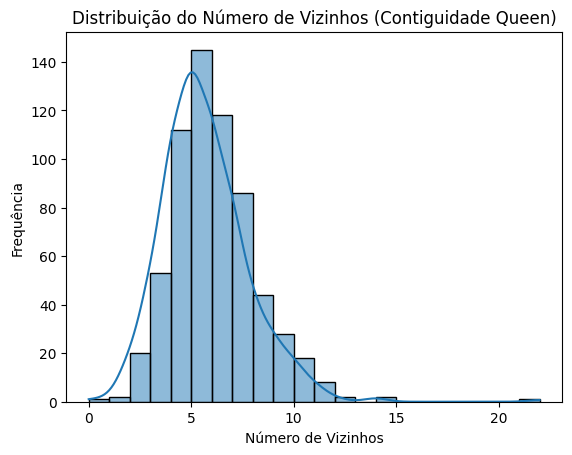

In [ ]:
#@title Histograma do número de municípios vizinhos

w_queen = Queen.from_dataframe(df)

num_neighbors = [w_queen.cardinalities[neigh] for neigh in w_queen.neighbors]

sns.histplot(num_neighbors, bins=range(min(num_neighbors), max(num_neighbors)+1), kde=True)
plt.title('Distribuição do Número de Vizinhos (Contiguidade Queen)')
plt.xlabel('Número de Vizinhos')
plt.ylabel('Frequência')
plt.show()

In [ ]:
y_model = df['IC2014'].values
X_model = df[['Area_Km2', 'CAER', 'CAEC',
           'RTF', 'IndRiq', 'TMI', 'TMP', 'TM1539', 'TM6069', 'TAE03',
           'IndEsc', 'Agrop']]

model_SLM = GM_Lag(
    y_model, X_model,
    w=w_queen,
    name_y='IC2014',
    name_x=['Area_Km2', 'CAER', 'CAEC',
           'RTF', 'IndRiq', 'TMI', 'TMP', 'TM1539', 'TM6069', 'TAE03',
           'IndEsc', 'Agrop']
)

print(model_SLM.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :      IC2014                Number of Observations:         640
Mean dependent var  :      0.2430                Number of Variables   :          14
S.D. dependent var  :      0.0913                Degrees of Freedom    :         626
Pseudo R-squared    :      0.1650
Spatial Pseudo R-squared:  0.1652

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT         0.05554         0.03632         1.52918         0.12622
            Area_Km2         0.00007         0.00001         4.89111         0.00000
                CAER         0.00077      

In [ ]:
y_queen = df['IC2014'].values
X_queen = df[['Area_Km2', 'IPDM', 'CAER', 'CAEC',
           'RTF', 'IndRiq', 'TMI', 'TMP', 'TM1539', 'TM6069',
           'IndLong', 'TAE03', 'TDISM',
           'IndEsc', 'populacao', 'dens_demog']]

model_SLM_queen = GM_Lag(
    y_queen, X_queen,
    w=w_queen,
    name_y='IC2014',
    name_x=['Area_Km2', 'IPDM', 'CAER', 'CAEC',
           'RTF', 'IndRiq', 'TMI', 'TMP', 'TM1539', 'TM6069',
           'IndLong', 'TAE03', 'TDISM',
           'IndEsc', 'populacao', 'dens_demog']
)

print(model_SLM_queen.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :      IC2014                Number of Observations:         640
Mean dependent var  :      0.2430                Number of Variables   :          18
S.D. dependent var  :      0.0913                Degrees of Freedom    :         622
Pseudo R-squared    :      0.1781
Spatial Pseudo R-squared:  0.1802

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT       -15.88295        11.48526        -1.38290         0.16670
            Area_Km2         0.00006         0.00001         4.13716         0.00004
                IPDM        11.12352      

O teste de Anselin-Kelejian para a regressão com a matriz de pesos espaciais calculada por meio da contiguidade Queen atestou um p-valor de 0.0134, indicando que os resíduos da regressão possuem autocorrelação espacial. O modelo, portanto, não captura suficientemente as dependências das variáveis no espaço tal qual aquele calculado a partir da matriz de distância inversa, sendo descartado para análises futuras.

### **Validação cruzada**

Nesta seção, vale o destaque para o método de avaliação dos modelos, uma vez que utilizou-se do $Spatial$ $Pseudo$ $R^2$ ao invés do $R^2$, que parte do pressuposto de que as observações são independentes entre si. Em modelos de regressão espacial, a dependência espacial é incorporada explicitamente pelo termo $ρWy$, que viola os pressupostos de independência.

In [ ]:
df_reg = df[['Area_Km2', 'CAER', 'CAEC', 'RTF', 'IndRiq', 'TMI', 'TMP', 'TM1539', 'TM6069', 'TAE03', 'IndEsc', 'Agrop', 'Gini']]

In [ ]:
def loocv_sml_lag(df, X, y, features):
    n = len(df)
    predictions = np.zeros(n)

    X = X.reset_index(drop=True)
    df = df.reset_index(drop=True)
    y = pd.Series(y).reset_index(drop=True)

    # Calcular a matriz de distancia para toda nova instancia (afeta a normalização)
    coords = np.array(df[['x_centroid', 'y_centroid']])

    dist_matrix = distance_matrix(coords, coords)
    np.fill_diagonal(dist_matrix, np.inf)

    inv_dist_matrix = 1 / dist_matrix
    inv_dist_matrix[np.isinf(inv_dist_matrix)] = 0
    weights_matrix = inv_dist_matrix.copy()
    weights_matrix /= weights_matrix.sum(axis=1)[:, np.newaxis]


    X_const = X.copy()
    X_const['constant'] = 1  # Só funciona se adicionar constante previamente, nao alterar

    features_with_const = ['constant'] + features


    for i in tqdm(range(n)):
        X_train = X_const.drop(index=i).reset_index(drop=True)
        y_train = y.drop(index=i).reset_index(drop=True)

        W_train_matrix = np.delete(np.delete(weights_matrix, i, axis=0), i, axis=1)
        W_train = full2W(W_train_matrix)

        model = ML_Lag(
            y_train.values,
            X_train[features_with_const].values,
            w=W_train,
            name_y='target_variable',
            name_x=features_with_const
        )

        X_test = X_const.loc[[i], features_with_const].values

        W_i = weights_matrix[i, :]
        W_i = np.delete(W_i, i)

        y_train_no_i = y_train.values
        spatial_lag = W_i @ y_train_no_i

        # betas: do intercepto até o penúltimo coeficiente
        betas = model.betas[:-1].flatten()  # excluir o último coeficiente (rho)
        rho = model.betas[-1][0]            # o último coeficiente é rho

        y_pred = X_test @ betas + rho * spatial_lag
        predictions[i] = y_pred[0]

    return predictions

In [ ]:
#@title LOOCV

features = ['Area_Km2', 'CAER', 'CAEC', 'RTF', 'IndRiq', 'TMI', 'TMP', 'TM1539', 'TM6069', 'TAE03', 'IndEsc', 'Agrop']

X = df_reg[features]
y = (df['TR2014'] * 1000 / df['populacao']).values

predictions = loocv_sml_lag(df, X, y, features)

100%|██████████| 640/640 [17:28<00:00,  1.64s/it]


In [ ]:
y_true = (df['TR2014'] * 1000 / df['populacao']).values
y_pred = predictions

mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)
r2 = r2_score(y_true, y_pred)



print(f'Erro Médio Absoluto (MAE): {mae}')
print(f'Raiz do Erro Quadrático Médio (RMSE): {rmse}')
print(f'Coeficiente de Determinação (R²): {r2}')

Erro Médio Absoluto (MAE): 0.9361660775587991
Raiz do Erro Quadrático Médio (RMSE): 1.5505545017993838
Coeficiente de Determinação (R²): 0.5194870592985998


In [ ]:
#@title Distribuição: Valores previstos x reais

df_resultados = pd.DataFrame([y_true, y_pred]).T
df_resultados.columns = ['y_true', 'y_pred']
df_resultados['Erro absoluto'] = abs(df_resultados['y_true'] - df_resultados['y_pred'])

fig = px.scatter(df_resultados, x="y_true", y="y_pred", color="Erro absoluto", title="Validação cruzada Leave One Out", color_continuous_scale='Agsunset')

fig.update_layout(
    xaxis_title="Taxa de roubo",
    yaxis_title="Taxa de roubo prevista",
    showlegend=True)

fig.add_trace(
    go.Scatter(
        x=[y_true.min(), y_true.max()],
        y=[y_true.min(), y_true.max()],
        mode='lines',
        line=dict(color='black'),
        showlegend=False
    )
)

fig.show()

In [ ]:
#@title Morran's I e Geary's C para resíduos

df_resultados = pd.DataFrame([y_true, y_pred]).T
df_resultados.columns = ['y_true', 'y_pred']

residuos = df_resultados['y_true'] - df_resultados['y_pred']
moran = esda.Moran(residuos, w)
print(f'Morans I: {moran.I}')

geary = Geary(residuos, w)
print(f"Geary's C: {geary.C}, p-value: {geary.p_sim}")

Morans I: 0.06343805260744269
Geary's C: 0.9324974453455425, p-value: 0.001


---

## **GNN**

As Graph Neural Networks (GNNs) são modelos de aprendizagem profunda projetados para lidar com dados que possuem estrutura de grafo. Em se tratando de dados espaciais, as GNNs modelam explicitamente as vizinhanças e permitem que cada nó aprenda uma representação latente que considera atributos vizinhos. Cada nó do grafo,portanto, representa um município e possui um vetor de atributos com as características socioeconômicas.

#### **Arquitetura GAE**

As arquiteturas do tipo Graph Autoencoder mapeiam grafos a um espaço de características latentes para gerar um embedding de cada nó. O modelo é treinado de forma que essa representação capture a estrutura topológica da rede original. Depois, um decoder calcula a similaridade de cada par de nós, e uma função de ativação define se deve ou não existir uma aresta entre nós durante a reconstrução da rede. As GAEs são treinadas para minimizar a loss entre a real matriz de adjacências e decodificada.

#### **Por quê treinar um modelo para "aprender as features"?**

As representações latentes dos dados capturam suas características mais relevantes, performando uma redução na dimensionalidade das features de modo a capturar padrões não lineares. A ideia é facilitar tarefas como classificação supervisionada e clusterização.

#### **Arquitetura NAGAE**

Para além de um Graph Autoencoder, a arquitetura utilizada aqui (NAGAE) adiciona mecanismos de atenção ao treinamento. Esses mecanismos atuam de forma similar (mas não análoga) ao mecanismos de atenção dos transformers. Aqui, ao invés de calcular a "atenção" entre diferentes palavras dado um contexto, o modelo avalia as relações entre nós conectados, modificando dinamicamente a estrutura da rede. Assim, os pesos se ajustam conforme a topologia e aos valores de cada nó. Para grafos heterogêneos ou grafos onde nem todas as conexões são igualmente relevantes, os modelos que incorporam atenção performam melhor do que os GAE's comuns.

In [ ]:
#@title Pré processamento

df_gnn = df[['Area_Km2', 'IPDM', 'CAER', 'CAEC',
           'RTF', 'IndRiq', 'TMI', 'TMP', 'TM1539', 'TM6069',
            'TAE03','IndLong',
            'Prof5ano', 'Prof9ano', 'TDISM',
           'IndEsc', 'populacao', 'Agrop', 'Gini', 'Indústria', 'AdmPub', 'ServExc',
          'ValAdic', 'ImpLiq', 'PIB', 'PIBpc', 'x_centroid', 'y_centroid']]

feature_columns = [col for col in df_gnn.columns if col not in ['x_centroid', 'y_centroid']]

scaler = StandardScaler()
x = scaler.fit_transform(df_gnn[feature_columns])

x = torch.tensor(x, dtype=torch.float)

In [ ]:
#@title Criação do grafo a partir da matriz de pesos espaciais W

G = w_knn.to_networkx()


edge_index = torch.tensor(list(G.edges()), dtype=torch.long).t().contiguous()
if 'weight' in next(iter(G.edges(data=True)))[-1]:
    edge_attr = torch.tensor([data['weight'] for _, _, data in G.edges(data=True)], dtype=torch.float).unsqueeze(1)
else:
    edge_attr = None

In [ ]:
#@title Definição do modelo

class NAGAE(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_heads=2):
        super(NAGAE, self).__init__()
        # Encoder
        self.conv1 = GATConv(num_features, hidden_channels, heads=num_heads, dropout=0.1)
        self.conv2 = GATConv(hidden_channels * num_heads, hidden_channels, heads=num_heads, dropout=0.1)
        # Decoder
        self.decoder = torch.nn.Linear(hidden_channels * num_heads, num_features)

    def encode(self, x, edge_index):
        x = F.leaky_relu(self.conv1(x, edge_index), negative_slope=0.02)
        x = F.leaky_relu(self.conv2(x, edge_index), negative_slope=0.02)
        return x

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x, edge_index):
        z = self.encode(x, edge_index)
        return self.decode(z)

In [ ]:
#@title Hiperparâmetros

learning_rate = 0.0005
weight_decay = 1e-5
hidden_channels = 16
num_heads = 2
dropout_rate = 0.1
max_epochs = 5000
patience = 300

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# mover data para a gpu tambem
data = Data(x=x, edge_index=edge_index)
if edge_attr is not None:
    data.edge_attr = edge_attr

data.x = data.x.to(device)
data.edge_index = data.edge_index.to(device)

In [ ]:
#@title Testando as curvas de validação do modelo

k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=120)
fold_results = []

num_nodes = data.num_nodes
indices = np.arange(num_nodes)

logs = {
    'train_losses': {},
    'val_losses': {},
    'val_mae': {},
    'val_rmse': {}
}

for fold, (train_idx, val_idx) in enumerate(kf.split(indices)):
    print(f'\n### Fold {fold + 1}/{k_folds} ###')

    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    val_mask = torch.zeros(num_nodes, dtype=torch.bool)

    train_mask[train_idx] = True
    val_mask[val_idx] = True

    data.train_mask = train_mask.to(device)
    data.val_mask = val_mask.to(device)

    model = NAGAE(num_features=x.shape[1], hidden_channels=hidden_channels, num_heads=num_heads).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion = torch.nn.MSELoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.2,
        patience=100,
        verbose=True
    )

    best_val_loss = np.inf
    patience_counter = 0
    best_model_path = f'best_nagae_model_fold_{fold + 1}.pth'

    train_losses = []
    val_losses = []
    val_mae_current_list = []
    val_rmse_current_list = []

    current_lr = optimizer.param_groups[0]['lr']

    for epoch in range(1, max_epochs + 1):
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)

        # calcular loss apenas no treino
        loss = criterion(out[data.train_mask], data.x[data.train_mask])
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        # avalia na validação
        model.eval()
        with torch.no_grad():
            out_val = model(data.x, data.edge_index)
            val_loss = criterion(out_val[data.val_mask], data.x[data.val_mask]).item()
            val_mae_current = mean_absolute_error(
                data.x[data.val_mask].cpu().numpy(),
                out_val[data.val_mask].cpu().numpy()
            )
            val_rmse_current = mean_squared_error(
                data.x[data.val_mask].cpu().numpy(),
                out_val[data.val_mask].cpu().numpy(),
                squared=False
            )

        val_losses.append(val_loss)
        val_mae_current_list.append(val_mae_current)
        val_rmse_current_list.append(val_rmse_current)
        scheduler.step(val_loss)

        new_lr = optimizer.param_groups[0]['lr']
        if new_lr < current_lr:
            print(f'Fold {fold +1}, Época {epoch}: Learning rate reduzido de {current_lr} para {new_lr}')
            current_lr = new_lr

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), best_model_path)
        else:
            patience_counter += 1

        # callback 300 épocas
        if epoch % 300 == 0:
            print(f'Época {epoch}, Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}, Val MAE: {val_mae_current:.4f}, Val RMSE: {val_rmse_current:.4f}')

        # early stopping
        if patience_counter >= patience:
            print(f'Early stopping na época {epoch}')
            break

    model.load_state_dict(torch.load(best_model_path))

    # logs para plot
    fold_number = fold + 1
    logs['train_losses'][fold_number] = train_losses
    logs['val_losses'][fold_number] = val_losses
    logs['val_mae'][fold_number] = val_mae_current_list
    logs['val_rmse'][fold_number] = val_rmse_current_list
    fold_results.append({
        'Fold': fold + 1,
        'Best Val Loss': best_val_loss,
        'Final Val MAE': val_mae_current_list[-1],
        'Final Val RMSE': val_rmse_current_list[-1],
        'Total Epochs': epoch
    })



### Fold 1/5 ###
Época 300, Loss: 0.5563, Val Loss: 0.6772, Val MAE: 0.5063, Val RMSE: 0.7293
Época 600, Loss: 0.5114, Val Loss: 0.6531, Val MAE: 0.4951, Val RMSE: 0.7152
Época 900, Loss: 0.4900, Val Loss: 0.6431, Val MAE: 0.4953, Val RMSE: 0.7117
Fold 1, Época 1020: Learning rate reduzido de 0.0005 para 0.0001
Fold 1, Época 1121: Learning rate reduzido de 0.0001 para 2e-05
Época 1200, Loss: 0.4778, Val Loss: 0.6431, Val MAE: 0.4960, Val RMSE: 0.7122
Early stopping na época 1220

### Fold 2/5 ###
Época 300, Loss: 0.5956, Val Loss: 0.6666, Val MAE: 0.5214, Val RMSE: 0.7371
Época 600, Loss: 0.5085, Val Loss: 0.6638, Val MAE: 0.5184, Val RMSE: 0.7366
Fold 2, Época 627: Learning rate reduzido de 0.0005 para 0.0001
Fold 2, Época 728: Learning rate reduzido de 0.0001 para 2e-05
Early stopping na época 826

### Fold 3/5 ###
Época 300, Loss: 0.5460, Val Loss: 1.7223, Val MAE: 0.5388, Val RMSE: 1.1873
Época 600, Loss: 0.4977, Val Loss: 1.6932, Val MAE: 0.5321, Val RMSE: 1.1785
Fold 3, Época 63

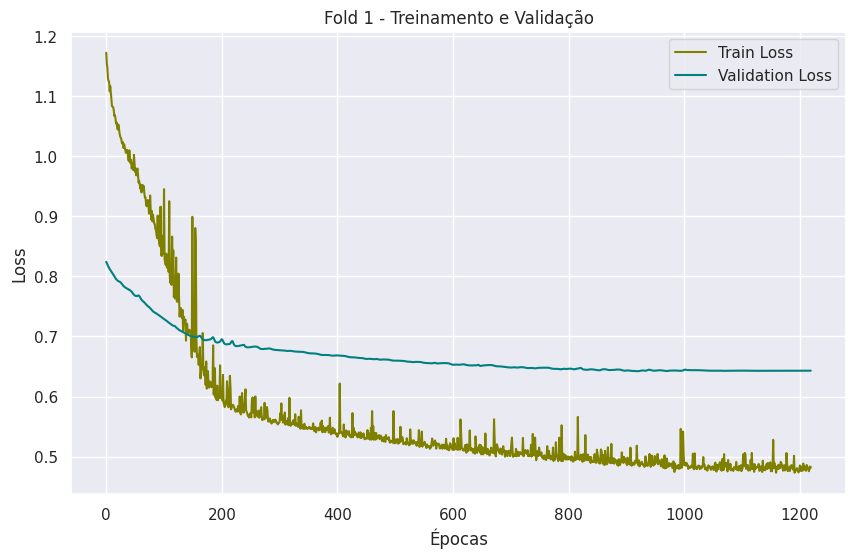

In [ ]:
#@title Logs do primeiro fold
plt.figure(figsize=(10,6))
sns.set_theme()
plt.plot(logs['train_losses'][1], label='Train Loss', color = 'olive')
plt.plot(logs['val_losses'][1], label='Validation Loss', color='teal')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title(f'Fold {1} - Treinamento e Validação')
plt.legend()
plt.show()

## **Leave One Out CV**

Antes de obter de fato os embeddings, foi feito um pequeno processo de validação para avaliar algumas hipóteses. Num primeiro momento, não se sabia se os dados disponíveis para o modelo seriam suficientes para a tarefa criada; a validação, portanto, previa evitar o overfitting. Depois, buscou-se encontrar um conjunto de hiperparâmetros adequado à tarefa. Para isso, realizou-se o processo intensivo de validação cruzada por meio do método "Leave One Out".

Para cada município, ocultava-se as conexões dele durante o treino e fornecia a tarefa à rede de modelar a estrutura do grafo. Posteriormente, introduzia-se o novo nó como uma instância a ser predita a partir dos embeddings obtidos, repetindo o processo a cada iteração.

## **Detalhes da implementação**

Explica-se a seguir, em detalhes, a arquiteura da rede utilizada.



- **Encoder**: aprende a representar cada nó do grafo em um espaço de baixa dimensão (embeddings) utilizando camadas de atenção em grafos. Aqui, o encoder é dado por duas camadas do tipo "GATConv" (que incorporam os mecanismos de atenção). Para cada par de nós conectados (i,j), as camadas do encoder calculam a similaridade, que indicam o "quão relevante" o nó $j$ é para explicar o nó $i$. As "cabeças de atenção" incorporam a informação da topologia do grafo, aprendendo tipos de relação diferente a depender da estrutura da rede.

- Decoder: Reconstrói as características originais dos nós a partir das embeddings geradas pelo encoder. A camada de saída linear transforma de volta para o espaço das características originais.

- Todas as funções de ativação são **Leaky Relu's**, que performou melhor so que a **"Relu"** diante da robustez dos gráficos. Os hiperparâmetros foram testados durante as etapas de validação, optou-se pelo seguinte conjunto:


1. **weight_decay** = 1e-5
2. **hidden_channels** = 16
3. **num_heads** = 2
4. learning_rate = 0.0005, monitorando a loss da validação com paciência de 50 épocas. O fator de redução era 0,5.
5. max_epochs = 5000
6. patience = 300

O tamanho das embeddings também podem ser considerados um "hiperparêmetro" neste caso. Utilizou-se da combinação "**num_heads**" * "**hidden_channel**", validados a seguir.

In [ ]:
#@title Pré-processamento

learning_rate = 0.0005
weight_decay = 1e-5
hidden_channels = 16
num_heads = 2
dropout_rate = 0.1
max_epochs = 5000
patience = 300


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = Data(x=x, edge_index=edge_index)
if edge_attr is not None:
    data.edge_attr = edge_attr

data = data.to(device)

all_preds = []
all_labels = []

num_nodes = data.num_nodes
indices = np.arange(num_nodes)

In [ ]:
#@title Leave One Out Cross Validation

for node_idx in tqdm(range(num_nodes), desc="LOOCV Progress"):
    train_val_indices = np.delete(indices, node_idx)

    train_indices, val_indices = train_test_split(
        train_val_indices, test_size=0.2, random_state=42
    )

    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    val_mask = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(num_nodes, dtype=torch.bool)

    train_mask[train_indices] = True
    val_mask[val_indices] = True
    test_mask[node_idx] = True

    data.train_mask = train_mask.to(device)
    data.val_mask = val_mask.to(device)
    data.test_mask = test_mask.to(device)

    x_train = data.x.clone()
    x_train[data.test_mask] = 0

    model = NAGAE(
        num_features=data.x.shape[1],
        hidden_channels=hidden_channels,
        num_heads=num_heads,
    ).to(device)

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=learning_rate,
        weight_decay=weight_decay
    )
    criterion = torch.nn.MSELoss()

    best_val_loss = np.inf
    patience_counter = 0

    for epoch in range(1, max_epochs + 1):
        model.train()
        optimizer.zero_grad()
        out = model(x_train, data.edge_index)

        loss = criterion(out[data.train_mask], data.x[data.train_mask])
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            out_val = model(data.x, data.edge_index)
            val_loss = criterion(out_val[data.val_mask], data.x[data.val_mask])

        if val_loss.item() < best_val_loss:
            best_val_loss = val_loss.item()
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break

    model.load_state_dict(best_model_state)

    model.eval()
    with torch.no_grad():
        out_test = model(data.x, data.edge_index)
        pred = out_test[data.test_mask].cpu().numpy()
        label = data.x[data.test_mask].cpu().numpy()

        all_preds.append(pred)
        all_labels.append(label)

all_preds = np.vstack(all_preds)
all_labels = np.vstack(all_labels)

r2_scores = []
for i in range(all_labels.shape[1]):
    r2 = r2_score(all_labels[:, i], all_preds[:, i])
    r2_scores.append(r2)
    print(f'R^2 para a característica {i}: {r2:.4f}')

LOOCV Progress:  96%|█████████▌| 613/640 [1:35:10<04:25,  9.82s/it]

## **Obtendo embeddings a partir de aprendizado semi-supervisionado**



In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
#@title Definindo o modelo

class NAGAE(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_heads=2):
        super(NAGAE, self).__init__()
        # Encoder
        self.conv1 = GATConv(num_features, hidden_channels, heads=num_heads, dropout=0.1)
        self.conv2 = GATConv(hidden_channels * num_heads, hidden_channels, heads=num_heads, dropout=0.1)
        # Decoder
        self.decoder = torch.nn.Linear(hidden_channels * num_heads, num_features)

    def encode(self, x, edge_index):
        x = F.leaky_relu(self.conv1(x, edge_index), negative_slope=0.02)
        x = F.leaky_relu(self.conv2(x, edge_index), negative_slope=0.02)
        return x

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x, edge_index):
        z = self.encode(x, edge_index)
        return self.decode(z)

In [ ]:
#@title Hiperparametros validados

learning_rate = 0.0005
weight_decay = 1e-5
hidden_channels = 16
num_heads = 2
dropout_rate = 0.1
max_epochs = 5000
patience = 200
embedding_dim = 32

In [ ]:
#@title Matriz de pesos, atributos e objeto "Data"

df_gnn = df[['Area_Km2', 'IPDM', 'CAER', 'CAEC',
           'RTF', 'IndRiq', 'TMI', 'TMP', 'TM1539', 'TM6069',
            'TAE03','IndLong',
            'Prof5ano', 'Prof9ano', 'TDISM',
           'IndEsc', 'populacao', 'Agrop', 'Gini', 'Indústria', 'AdmPub', 'ServExc',
          'ValAdic', 'ImpLiq', 'PIB', 'PIBpc', 'x_centroid', 'y_centroid']]

feature_columns = [col for col in df_gnn.columns if col not in ['x_centroid', 'y_centroid']]
scaler = StandardScaler()
x = scaler.fit_transform(df_gnn[feature_columns])
x = torch.tensor(x, dtype=torch.float)

G  = w_knn.to_networkx()
arestas = list(G.edges())
edge_index = torch.tensor(arestas, dtype=torch.long).t().contiguous()

data = Data(x=x, edge_index=edge_index)

data.x = data.x.to(device)
data.edge_index = data.edge_index.to(device)

In [ ]:
#@title Inicializando o modelo

model = NAGAE(num_features=data.num_features,
             hidden_channels=hidden_channels,
             num_heads=num_heads).to(device)

model = NAGAE(num_features=x.shape[1], hidden_channels=hidden_channels, num_heads=num_heads).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# scheduler para monitorar o learning rate adaptativo
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=50, verbose=True)


criterion = torch.nn.MSELoss()

In [ ]:
#@title Treino e validação

num_nodes = data.num_nodes
indices = np.arange(num_nodes)
np.random.shuffle(indices)


train_size = int(0.8 * num_nodes)
train_indices = indices[:train_size]
val_indices = indices[train_size:]

# data masks
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_indices] = True
val_mask[val_indices] = True

data.train_mask = train_mask
data.val_mask = val_mask

data.train_mask = data.train_mask.to(device)
data.val_mask = data.val_mask.to(device)

In [ ]:
best_val_loss = float('inf')
patience_counter = 0
train_losses = []
val_losses = []

for epoch in range(1, max_epochs + 1):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.x[data.train_mask])
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        out_val = model(data.x, data.edge_index)
        val_loss = criterion(out_val[data.val_mask], data.x[data.val_mask])

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    if epoch % 100 == 0 or epoch == 1:
        print(f'Epoch: {epoch}, Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'Early stopping at epoch: {epoch}')
            break

    scheduler.step(val_loss)

Epoch: 1, Loss: 1.4110, Val Loss: 1.0128
Epoch: 100, Loss: 0.9472, Val Loss: 0.7159
Epoch: 200, Loss: 0.7046, Val Loss: 0.6467
Epoch: 300, Loss: 0.5716, Val Loss: 0.6325
Epoch: 400, Loss: 0.5622, Val Loss: 0.6319
Epoch: 500, Loss: 0.5527, Val Loss: 0.6319
Epoch: 600, Loss: 0.5492, Val Loss: 0.6319
Early stopping at epoch: 660


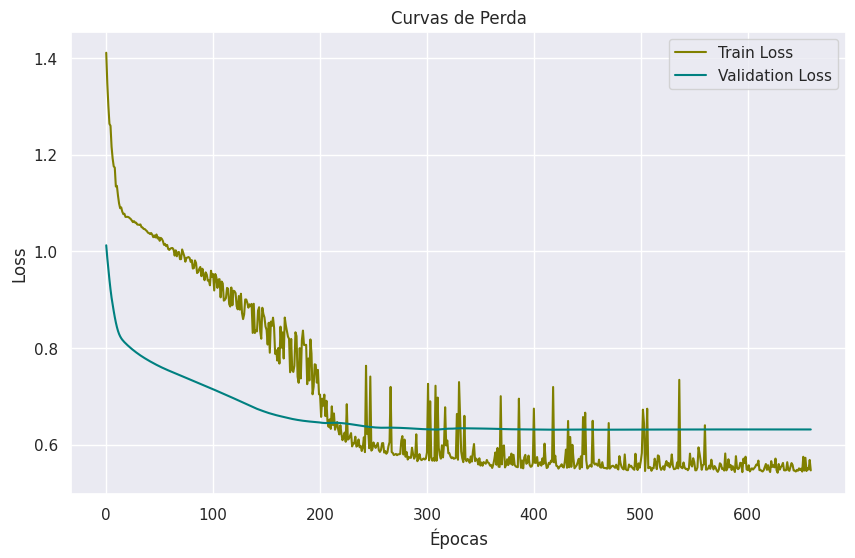

In [ ]:
sns.set_theme()
plt.figure(figsize=(10,6))
plt.plot(train_losses, label='Train Loss', color = 'olive')
plt.plot(val_losses, label='Validation Loss', color='teal')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.title('Curvas de Perda')
plt.show()

In [ ]:
#@title Salvar os Embeddings

model.load_state_dict(torch.load('best_model.pt'))
model.eval()

with torch.no_grad():
    embeddings = model.encode(data.x, data.edge_index).cpu().numpy()

df_embeddings = pd.DataFrame(embeddings, index=df_gnn.index)
df_embeddings.to_csv('embeddings_municipios.csv', index_label='municipio')

In [ ]:
df_embeddings['Municipio'] = df['Municipio']

In [ ]:
#@title UMAP para visualizar embeddings

embeddings = df_embeddings.drop(columns='Municipio').values
umap_reducer = umap.UMAP(n_components=2, n_neighbors=10, random_state=42)

embeddings_umap = umap_reducer.fit_transform(embeddings)

(640, 2)


In [ ]:
embeddings_umap_df = pd.DataFrame(embeddings_umap, columns=['UMAP_1', 'UMAP_2'])
df_combined = pd.concat([df_embeddings, embeddings_umap_df], axis=1)

In [ ]:
df_embeddings['Região imediata'] = df['RGIme']

embeddings_umap_df = pd.DataFrame(embeddings_umap, columns=['UMAP_1', 'UMAP_2'])
df_combined = pd.concat([df_embeddings, embeddings_umap_df], axis=1)

fig = px.scatter(
    df_combined,
    x='UMAP_1',
    y='UMAP_2',
    color='Região imediata',
    # hover_data=['municipio'],
    title='Visualização dos Embeddings com UMAP - Colorido por Região Geográfica Imediata',
    labels={
        'UMAP_1': 'UMAP 1',
        'UMAP_2': 'UMAP 2',
        'Nome Região Geográfica Imediata': 'Região Geográfica Imediata'
    },
    width=800,
    height=600
)

fig.update_coloraxes(
    colorbar=dict(showticklabels=False)
)

fig.show()

In [ ]:
#@title Modelo de Regressão com os embeddings

y_model = (df['TR2014'] * 1000 / df['populacao']).values
X_model = df_embeddings[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]]

model_SLM = GM_Lag(
    y_model, X_model,
    w=w_knn,
    name_y='TR2014',
    name_x=''
)

print(model_SLM.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :      TR2014                Number of Observations:         640
Mean dependent var  :      1.5583                Number of Variables   :          34
S.D. dependent var  :      2.2386                Degrees of Freedom    :         606
Pseudo R-squared    :      0.7186
Spatial Pseudo R-squared:  0.6158

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT        -0.16722         0.33974        -0.49221         0.62257
               var_1        -0.17086         0.52285        -0.32678         0.74383
               var_2         0.62820      

In [ ]:
#@title Autocorrelação dos resíduos

previsoes_embedding = model_SLM.predy.flatten()
valores_reais = (df['TR2014'] * 1000 / df['populacao']).values

residuo = previsoes_embedding - valores_reais

moran_embedding = esda.Moran(residuo, w_knn)
gearys_embeddinf = esda.Geary(residuo, w_knn)

print(f'Morans I: {moran_embedding.I}')
print(f'Gearys C: {gearys_embeddinf.C}')

Morans I: -0.0888334322325319
Gearys C: 1.0756096649006348


---

## **Gradient Boost para teste**

In [7]:
import pandas as pd
import numpy as np

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import LeaveOneOut, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


In [8]:
df_gradient = df[['Area_Km2', 'IPDM', 'CAER', 'CAEC',
       'RTF', 'IndRiq', 'TMI', 'TMP', 'TM1539', 'TM6069', 'IndLong', 'TAE03',
       'Prof5ano', 'Prof9ano', 'TDISM', 'IndEsc', 'populacao', 'homens',
       'mulheres', 'razao_sexo', 'id_media', 'dens_demog', 'Agrop',
       'Indústria', 'AdmPub', 'ServExc', 'ValAdic', 'ImpLiq', 'PIB', 'Gini', 'IC2014']]

In [9]:
# Definir as features e a variável alvo
features = ['Area_Km2', 'CAER', 'CAEC',
           'RTF', 'IndRiq', 'TMI', 'TMP', 'TM1539', 'TM6069', 'TAE03', 'TDISM',
           'IndEsc', 'populacao', 'Agrop', 'Gini']

X = df_gradient[features]
y = df_gradient['IC2014']

In [10]:
from re import L
scaler = StandardScaler()
df_gradient[features] = scaler.fit_transform(df_gradient[features])

loo = LeaveOneOut()

In [11]:
y_pred = []

for train_index, test_index in tqdm(loo.split(X), total=loo.get_n_splits(X), desc="LOOCV Progress"):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = GradientBoostingRegressor()
    model.fit(X_train, y_train)

    y_pred.append(model.predict(X_test)[0])

LOOCV Progress: 100%|██████████| 640/640 [04:54<00:00,  2.17it/s]


In [ ]:
#@title Depois de incluir Gini

mse = mean_squared_error(y, y_pred)
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'R² Score: {r2:.4f}')

In [ ]:
#@title Antes de incluir Gini

mse = mean_squared_error(y, y_pred)
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'R² Score: {r2:.4f}')

In [ ]:
residuals = y - y_pred

print(f'Mean of Residuals: {residuals.mean():.4f}')
print(f'Standard Deviation of Residuals: {residuals.std():.4f}')

---

## **Miscelanea**

In [ ]:
path_regiao_imediata = '/content/Analise-Criminal-no-Brasil/Shapefiles_auxiliares/regiao_geografica_imediata/Regiao Geografica Imediata.shp'

In [ ]:
regioes_imediatas = gpd.read_file(path_regiao_imediata)
regioes_imediatas['geometry'] = regioes_imediatas['geometry'].simplify(0.01)
regioes_imediatas['constante'] = 1
geojson_regioes = json.loads(regioes_imediatas.to_json())

In [ ]:
moran = Moran(residuals, w)
print(f"Moran's I: {moran.I}, p-value: {moran.p_sim}")

In [ ]:
df['Cod'] = regioes_imediatas['Cod']

In [ ]:
coords = np.array(df[['x_centroid', 'y_centroid']])
dist_matrix = distance_matrix(coords, coords)

# Substituir as distâncias na diagonal (municipio consigo mesmo) por infinito para evitar divisão por zero
np.fill_diagonal(dist_matrix, np.inf)
inv_dist_matrix = 1 / dist_matrix
# Extrair os códigos das microrregiões
cod = df['RGInter'].values

# Criar uma matriz de máscara onde W_mask[i][j] = 1 se Cod[i] == Cod[j], senão 0
W_mask = (cod[:, np.newaxis] == cod[np.newaxis, :]).astype(float)
W_matrix = inv_dist_matrix * W_mask
# Somar os pesos de cada linha
row_sums = W_matrix.sum(axis=1, keepdims=True)

# Evitar divisão por zero substituindo zeros por um (temporariamente)
row_sums[row_sums == 0] = 1

# Normalizar os pesos
W_matrix_normalized = W_matrix / row_sums

# Substituir NaNs resultantes de divisão por zero (se houver) por 0
W_matrix_normalized = np.nan_to_num(W_matrix_normalized)
# Verificar algumas entradas
print("Exemplo de W_matrix_normalized:")
print(W_matrix_normalized[:5, :5])  # Exemplo das 5 primeiras linhas e colunas

# Verificar se as diagonais são 0
print("Verificação das diagonais:")
print(np.diag(W_matrix_normalized))


In [ ]:
# Converter a matriz completa para um objeto de pesos do libpysal
w = libpysal.weights.full2W(W_matrix_normalized)

## **Últimos testes de autocorrelação espacial no índice**

In [ ]:
#@title Matriz W completa (inversos das distancias)

coords = np.array(df[['x_centroid', 'y_centroid']])
dist_matrix = distance_matrix(coords, coords)
np.fill_diagonal(dist_matrix, np.inf)
inv_dist_matrix = 1 / dist_matrix


# k definido com validação
k = 640


nearest_neighbors_indices = np.argsort(dist_matrix, axis=1)[:, :k]
nearest_neighbors_distances = np.take_along_axis(dist_matrix, nearest_neighbors_indices, axis=1)

weights = 1 / nearest_neighbors_distances

weights[np.isinf(weights)] = 0
weights_normalized = weights / weights.sum(axis=1)[:, np.newaxis]

n = len(df)
W_matrix = np.zeros((n, n))

for i in range(n):
    W_matrix[i, nearest_neighbors_indices[i]] = weights_normalized[i]

w_cheia = libpysal.weights.full2W(W_matrix)

In [ ]:
#@title Matriz W knn (inversos das distancias)

coords = np.array(df[['x_centroid', 'y_centroid']])
dist_matrix = distance_matrix(coords, coords)
np.fill_diagonal(dist_matrix, np.inf)
inv_dist_matrix = 1 / dist_matrix


# k definido com validação
k = 11


nearest_neighbors_indices = np.argsort(dist_matrix, axis=1)[:, :k]
nearest_neighbors_distances = np.take_along_axis(dist_matrix, nearest_neighbors_indices, axis=1)

weights = 1 / nearest_neighbors_distances

weights[np.isinf(weights)] = 0
weights_normalized = weights / weights.sum(axis=1)[:, np.newaxis]

n = len(df)
W_matrix = np.zeros((n, n))

for i in range(n):
    W_matrix[i, nearest_neighbors_indices[i]] = weights_normalized[i]

w_knn = libpysal.weights.full2W(W_matrix)

In [ ]:
moran = esda.Moran(df['IC2014'], w_knn)
print(f'Morans I: {moran.I}')

In [ ]:
moran.p_sim

In [ ]:
from splot.esda import moran_scatterplot

In [ ]:
moran_scatterplot(moran)

In [ ]:
moran = esda.Moran(df['IC2014'], w_cheia)
print(f'Morans I: {moran.I}')

In [ ]:
df_sem = df[df['IC2014'] < 1]

## **Variogramas**

In [ ]:
#@title Adicionando o índice de Gini ao dataframe

gini = pd.read_csv('/content/gini_2010 - Página1.csv')
gini['Cod'] = gini['Cod'].astype(int)
gini['Gini'] = gini['Gini'].astype(str).str.replace(',', '.').astype(float)
df['Codigo sem digito'] = ((df['cod_ibge'] - (df['cod_ibge'] % 10)) / 10).astype(int)
df = df.merge(gini, left_on='Codigo sem digito', right_on='Cod', how='left')

df.drop('Codigo sem digito', axis=1, inplace=True)
df.drop('Município', axis=1, inplace=True)
df.drop('Cod', axis=1, inplace=True)

In [ ]:
#@title Moran's I do índice de Gini

moran = esda.Moran(df['Gini'], w)
print(f'Morans I: {moran.I}')

moran_kmeans = esda.Moran(df['Gini'], w_knn)
print(f'Morans I: {moran_kmeans.I}')

## **Rede neural desconsiderando espaço**

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
#@title Todas as features num pca

df_pca = df.copy()
df_pca = df_pca[['Area_Km2', 'IPDM', 'CAER', 'CAEC',
           'RTF', 'IndRiq', 'TMI', 'TMP', 'TM1539', 'TM6069',
            'TAE03','IndLong', 'TAE03',
            'Prof5ano', 'Prof9ano', 'TDISM',
           'IndEsc', 'populacao', 'Agrop', 'Gini', 'Indústria', 'AdmPub', 'ServExc',
          'ValAdic', 'ImpLiq', 'PIB', 'PIBpc']]

X = df_rede.drop('IC2014', axis=1).values
y = df_rede['IC2014'].values

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=42)  # 95% da variância
X_pca = pca.fit_transform(X_scaled)
print(f"Número de componentes selecionados: {pca.n_components_}")


In [ ]:
# Carregar os dados
df_rn = df_gradient.copy()  # Supondo que df_gradient já está carregado

df_rede = df_rn[['Area_Km2', 'CAER', 'CAEC',
           'RTF', 'IndRiq', 'TMI', 'TMP', 'TM1539', 'TM6069', 'TAE03',
           'IndEsc', 'Agrop', 'Gini', 'IC2014']]

# Separar features e target
X = df_rede.drop('IC2014', axis=1).values
y = df_rede['IC2014'].values

# Escalonar as features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
def criar_modelo(input_dim):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu',
                    kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu',
                    kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)

In [ ]:
k = 10 # Número de folds
num_epochs = 200
batch_size = 64

kfold = KFold(n_splits=k, shuffle=True, random_state=42)
r2_scores = []
mse_scores = []

r2_scores = []
mse_scores = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(X_pca)):
    X_train, X_val = X_pca[train_idx], X_pca[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    model = criar_modelo(input_dim=X_train.shape[1])

    history = model.fit(
        X_train, y_train,
        epochs=200,
        batch_size=16,
        validation_data=(X_val, y_val),
        callbacks=[early_stop, reduce_lr],
        verbose=0
    )

    # Previsões e Avaliação
    y_pred = model.predict(X_val).flatten()
    r2 = r2_score(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)
    r2_scores.append(r2)
    mse_scores.append(mse)

    print(f"Fold {fold+1} - R²: {r2:.4f}, MSE: {mse:.4f}")

print(f"\nResultado Médio da Validação Cruzada ({k}-fold):")
print(f"R² Médio: {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")
print(f"MSE Médio: {np.mean(mse_scores):.4f} ± {np.std(mse_scores):.4f}")


In [ ]:
print(f"\nResultado Médio da Validação Cruzada ({k}-fold):")
print(f"R² Médio: {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")
print(f"MSE Médio: {np.mean(mse_scores):.4f} ± {np.std(mse_scores):.4f}")


## **Análise subsequente: furto de veículos por habitante**

In [ ]:
df.columns

In [ ]:
y_veiculos = df['FV2014'] / df['populacao']

In [ ]:
Moran(y_veiculos, w_knn).I

### **Modelos de regressão**

In [ ]:
#@title Regressor com base na Matriz Knn
y = y_veiculos
X = df[['Area_Km2', 'CAER', 'CAEC',
           'RTF', 'IndRiq', 'TMI', 'TMP', 'TM1539', 'TM6069', 'TAE03', 'TDISM',
           'IndEsc', 'populacao', 'Agrop',]]# 'Gini']]

model_SLM = GM_Lag(
    y, X,
    w=w_knn,
    name_y='IC2014',
    name_x=['Area_Km2', 'CAER', 'CAEC',
           'RTF', 'IndRiq', 'TMI', 'TMP', 'TM1539', 'TM6069', 'TAE03', 'TDISM',
           'IndEsc', 'populacao', 'Agrop',]# 'Gini']
)

print(model_SLM.summary)

In [ ]:
#@title Regressor com base na Matriz densa
y = y_veiculos
X = df[['Area_Km2', 'CAER', 'CAEC',
           'RTF', 'IndRiq', 'TMI', 'TMP', 'TM1539', 'TM6069', 'TAE03', 'TDISM',
           'IndEsc', 'populacao', 'Agrop',]]# 'Gini']]

model_SLM = GM_Lag(
    y, X,
    w=w,
    name_y='IC2014',
    name_x=['Area_Km2', 'CAER', 'CAEC',
           'RTF', 'IndRiq', 'TMI', 'TMP', 'TM1539', 'TM6069', 'TAE03', 'TDISM',
           'IndEsc', 'populacao', 'Agrop',]# 'Gini']
)

print(model_SLM.summary)

In [ ]:
#@title Regressor com base na Matriz contiguidade Queen
y = y_veiculos
X = df[['Area_Km2', 'CAER', 'CAEC',
           'RTF', 'IndRiq', 'TMI', 'TMP', 'TM1539', 'TM6069', 'TAE03', 'TDISM',
           'IndEsc', 'populacao', 'Agrop',]]# 'Gini']]

model_SLM = GM_Lag(
    y, X,
    w=w_knn,
    name_y='IC2014',
    name_x=['Area_Km2', 'CAER', 'CAEC',
           'RTF', 'IndRiq', 'TMI', 'TMP', 'TM1539', 'TM6069', 'TAE03', 'TDISM',
           'IndEsc', 'populacao', 'Agrop',]# 'Gini']
)

print(model_SLM.summary)